<a href="https://colab.research.google.com/github/LiamDuero03/DS-Society-Project/blob/Liams-Branch/Full-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Project Lab: Quick Start Guide

Welcome to our first society project!

Our problem statement: Can we predict a city's 'Feels Like' temperature (Apparent Temperature) based solely on its size, location, and humidity?

In [3]:
import pandas as pd
import requests
from google.colab import userdata

# 1. Data Sourcing & Integration
In this section, we demonstrate how a Data Scientist pulls data from two distinct sources:
1. **Local Data Sourcing:** Internal "proprietary" data (e.g., City Population).
2. **Live API:** Real-time data enrichment (Live Weather).

### 1.1 Local Data Sourcing (Automated)
Instead of manual uploads, we pull our "internal" population data directly from our GitHub repository. This ensures all members are working with the same version of the data.

* **Primary Data Source:** The underlying dataset is the **World Cities Database**, originally sourced from [Kaggle](https://www.kaggle.com/datasets/max-mind/world-cities-database).
* **Storage Method:** Due to the large file size (3.1+ million rows), the CSV is hosted using **Git LFS (Large File Storage)**. This allows us to bypass GitHub's standard file limits and stream the data directly into our environment via Raw GitHub URLs.
* **Automation:** By using `pd.read_csv()` on the hosted URL, we eliminate the need for users to download local copies or manage large files manually.

| Column | Description |
| :--- | :--- |
| **city** | Standardized city name (lowercased for merging) |
| **pop** | Total population count |
| **lat / lng** | Geographic coordinates (Latitude and Longitude) |

In [1]:
import pandas as pd

# --- CONFIGURATION ---
GITHUB_CSV_URL = "https://media.githubusercontent.com/media/LiamDuero03/DS-Society-Project/refs/heads/main/worldcitiespop.csv"

# --- 1. DATA LOADING ---
try:
    # Use 'usecols' to load only what we need (saves RAM)
    # Use lowercase column names if your CSV has them; otherwise keep these
    internal_metadata_df = pd.read_csv(
        GITHUB_CSV_URL,
        low_memory=False,
        usecols=['City', 'Population', 'Latitude', 'Longitude']
    )

    # Standardize column names for ease of use
    internal_metadata_df.columns = ['city', 'pop', 'lat', 'lng']

    print(f"✅ Successfully loaded {len(internal_metadata_df):,} rows from GitHub.")

except Exception as e:
    print(f"❌ Error: {e}")
    print("Tip: Check your GitHub LFS settings or the file URL.")

# --- 2. DATA CLEANING & SELECTION ---
# We focus on unique cities and prioritize the records with the highest population
valid_unique_cities = (
    internal_metadata_df
    .dropna(subset=['pop'])               # Remove rows without population data
    .sort_values(by='pop', ascending=False) # Put largest cities at the top
    .drop_duplicates(subset=['city'])     # Keep only the largest version of each city
)

# Extract the top 50 cities for our API target list
target_cities = valid_unique_cities.head(50)['city'].tolist()

# --- 3. SUMMARY OUTPUT ---
print(f"✅ Selected the top {len(target_cities)} unique megacities for analysis.")
print("-" * 30)
print(f"Top 5 Cities: {', '.join(target_cities[:5])}...")
print("-" * 30)

# Display the first few rows of our cleaned dataset
valid_unique_cities.head()

✅ Successfully loaded 3,173,958 rows from GitHub.
✅ Selected the top 50 unique megacities for analysis.
------------------------------
Top 5 Cities: tokyo, shanghai, bombay, karachi, new delhi...
------------------------------


,city,pop,lat,lng
1544449,tokyo,31480498.0,35.685000,139.751389
570824,shanghai,14608512.0,31.045556,121.399722
1327914,bombay,12692717.0,18.975000,72.825833
2200161,karachi,11627378.0,24.905600,67.082200
1349146,new delhi,10928270.0,28.600000,77.200000


## 1.2 Live API
#### 1.2.1 Get your OpenWeatherMap API Key

We are combining static city data with live weather data. You need a personal key to "talk" to the weather server:
1. Go to [OpenWeatherMap.org](https://openweathermap.org/api) and create a free account.
2. Navigate to your **API Keys** tab and copy your default key.
3. *Note:* It can take up to 30-60 minutes for a new key to "activate."

#### 1.2.2 🛡️ Set up Colab Secrets
To keep our project secure, we **never** type our API keys directly into the code.
* Look at the left-hand sidebar in this Colab window.
* Click the **Key icon (Secrets)** 🔑.
* Click "Add new secret".
* Name: `OPENWEATHER_API_KEY`
* Value: Paste your key here.
* **Toggle the "Notebook access" switch to ON.**



In [26]:
import os

# List of files to remove
files_to_delete = ['live_weather_cache.csv']

for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"🗑️ Deleted: {file}")
    else:
        print(f"⚠️ {file} not found (already deleted).")

🗑️ Deleted: live_weather_cache.csv


In [2]:
import os
import pandas as pd
import requests
from google.colab import userdata

# --- 1. API SETUP & CACHING LOGIC ---
try:
    API_KEY = userdata.get('OPENWEATHER_API_KEY')
    print("✅ OpenWeather API Key successfully retrieved.")
except:
    print("❌ API Key missing. Please add 'OPENWEATHER_API_KEY' to Colab Secrets.")

def fetch_live_weather(city_list):
    """
    Fetches real-time weather data for a list of cities.
    Saves results to a local CSV to prevent unnecessary API calls.
    """
    CACHE_FILE = "live_weather_cache.csv"

    # Check if we already have data from a previous run
    if os.path.exists(CACHE_FILE):
        print(f"📦 Loading weather data from local cache: {CACHE_FILE}")
        return pd.read_csv(CACHE_FILE)

    print(f"🌐 Cache not found. Fetching live data for {len(city_list)} cities...")
    results = []
    base_url = "http://api.openweathermap.org/data/2.5/weather"

    # Loop through cities and collect data
    for i, city in enumerate(city_list):
        params = {'q': city, 'appid': API_KEY, 'units': 'metric'}

        # Simple progress indicator for beginners
        if (i + 1) % 10 == 0:
            print(f"   Progress: {i + 1}/{len(city_list)} cities processed...")

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                d = response.json()
                results.append({
                    'city_name': city.lower().strip(),
                    'temp': d['main']['temp'],
                    'feels_like': d['main']['feels_like'],
                    'humidity': d['main']['humidity'],
                    'pressure': d['main']['pressure'],
                    'condition': d['weather'][0]['description'],
                    'wind': d['wind']['speed']
                })
        except Exception as e:
            print(f"⚠️ Error fetching {city}: {e}")

    # Create DataFrame and save to CSV
    weather_df = pd.DataFrame(results)
    weather_df.to_csv(CACHE_FILE, index=False)
    print("✅ API calls complete. Results cached locally.")
    return weather_df

# --- 2. TARGET SELECTION ---
# We prioritize the top 50 unique cities with the highest verified populations
print("🧹 Cleaning population data to identify the top 50 target cities...")

# This logic ensures we get unique names and the highest recorded pop for each
valid_unique_cities = (
    internal_metadata_df.dropna(subset=['pop'])
    .sort_values(by='pop', ascending=False)
    .drop_duplicates(subset=['city'])
)

target_cities = valid_unique_cities.head(50)['city'].tolist()

# --- 3. EXECUTION ---
live_weather_df = fetch_live_weather(target_cities)

print("-" * 30)
print(f"📊 Weather Data Preview ({len(live_weather_df)} cities):")
live_weather_df.head()

✅ OpenWeather API Key successfully retrieved.
🧹 Cleaning population data to identify the top 50 target cities...
🌐 Cache not found. Fetching live data for 50 cities...
   Progress: 10/50 cities processed...
   Progress: 20/50 cities processed...
   Progress: 30/50 cities processed...
   Progress: 40/50 cities processed...
   Progress: 50/50 cities processed...
✅ API calls complete. Results cached locally.
------------------------------
📊 Weather Data Preview (50 cities):


,city_name,temp,feels_like,humidity,pressure,condition,wind
0,tokyo,5.19,3.07,64,1013,clear sky,2.57
1,shanghai,4.92,2.41,87,1026,light rain,3.00
2,bombay,26.99,27.66,54,1015,smoke,1.54
3,karachi,17.90,17.76,77,1019,smoke,1.54
4,new delhi,11.09,10.53,87,1021,mist,1.03


## 1.3 The Master Merger
We will now join our **Baseline Data** with our **Local Metadata** and then ping the **OpenWeather API** to get live temperature data for a subset of these cities.

In [4]:
# 1. Standardize the join column in our cleaned metadata
valid_unique_cities['city_match'] = valid_unique_cities['city'].astype(str).str.lower().str.strip()

# 2. Perform the Merge
# IMPORTANT: We merge with valid_unique_cities (not internal_metadata_df)
# This ensures we only match the high-population, unique records we already picked
master_df = pd.merge(
    valid_unique_cities,
    live_weather_df,
    left_on='city_match',
    right_on='city_name',
    how='inner' # 'inner' keeps only the 50 cities we successfully matched
)

# 3. Final Polish
# We drop the extra join columns (no need to drop duplicates here because valid_unique_cities is already clean!)
master_df = master_df.drop(columns=['city_match', 'city_name'])

# 4. Final Column Selection
master_df = master_df[['city', 'pop', 'temp', 'feels_like', 'humidity', 'wind', 'condition', 'lat', 'lng']]

print(f"🚀 Master Dataset Created! Row count: {len(master_df)}")
master_df.head(10)

🚀 Master Dataset Created! Row count: 50


,city,pop,temp,feels_like,humidity,wind,condition,lat,lng
0,tokyo,31480498.0,5.19,3.07,64,2.57,clear sky,35.685000,139.751389
1,shanghai,14608512.0,4.92,2.41,87,3.00,light rain,31.045556,121.399722
2,bombay,12692717.0,26.99,27.66,54,1.54,smoke,18.975000,72.825833
3,karachi,11627378.0,17.90,17.76,77,1.54,smoke,24.905600,67.082200
4,new delhi,10928270.0,11.09,10.53,87,1.03,mist,28.600000,77.200000
5,delhi,10928270.0,11.05,10.48,87,1.03,mist,28.666667,77.216667
6,manila,10443877.0,24.93,25.54,79,2.06,broken clouds,14.604200,120.982200
7,moscow,10381288.0,-3.10,-7.65,68,3.46,overcast clouds,55.752222,37.615556
8,seoul,10323448.0,-2.24,-6.28,64,3.09,broken clouds,37.598500,126.978300
9,sao paulo,10021437.0,23.01,23.35,76,5.66,broken clouds,-23.473293,-46.665803


#2. Preliminary EDA & Visualization
Goal: Understand the "shape" and "health" of the data.

## 2.1 Understanding the "Skeleton" (Structure)
First, we use basic Pandas commands to see what we are working with. Beginners should always start here to check for missing values or unexpected data types.

In [5]:
# Check the shape (Rows, Columns)
print(f"Dataset Dimensions: {master_df.shape}")

# See the data types and null counts
print("\n--- Data Summary ---")
print(master_df.info())

# Get basic statistics (Mean, Min, Max) for numerical columns
print("\n--- Numerical Statistics ---")
display(master_df.describe())

Dataset Dimensions: (50, 9)

--- Data Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        50 non-null     object 
 1   pop         50 non-null     float64
 2   temp        50 non-null     float64
 3   feels_like  50 non-null     float64
 4   humidity    50 non-null     int64  
 5   wind        50 non-null     float64
 6   condition   50 non-null     object 
 7   lat         50 non-null     float64
 8   lng         50 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.6+ KB
None

--- Numerical Statistics ---


,pop,temp,feels_like,humidity,wind,lat,lng
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.970887e+06,14.904200,14.394600,71.040000,2.744400,19.525525,46.171401
std,4.584767e+06,11.351342,12.831057,17.108251,1.801225,22.717912,71.419071
min,3.519177e+06,-8.060000,-8.060000,19.000000,0.000000,-37.813938,-118.242778
25%,3.951126e+06,5.377500,3.500000,64.250000,1.487500,8.539422,3.520972
50%,5.388496e+06,16.555000,15.875000,74.500000,2.365000,24.314328,72.721250
75%,8.675764e+06,24.692500,25.377500,82.000000,3.600000,33.937361,104.013959
max,3.148050e+07,34.140000,37.320000,97.000000,7.720000,59.894444,151.205475


## 2.2 The "Big Picture" Analysis (Pairplots)

Once we know our data is clean, we want to see how different variables interact. Instead of making dozens of individual charts, we use a **Pairplot**. This is a powerful "all-in-one" visualization that helps us spot patterns across the entire dataset instantly.

---

#### What is happening in this visualization?

A Pairplot creates a matrix of charts. To read it like a pro, look at these three distinct areas:

1. **The Diagonal (The Curves):**
Running from the top-left to the bottom-right, you see **Distribution Plots** (KDE). These show you the "shape" of a single variable—for example, where most city temperatures are concentrated.
2. **The Scatter Plots (The Dots):**
Every other square shows the relationship between **two different variables**.
* If the dots form a clear line, the variables are **correlated**.
* If the dots look like a messy cloud, there is **no relationship**.


3. **The Red Regression Lines (`kind='reg'`):**
These lines represent the "best fit" for the data.
* **Sloping Up:** As one value goes up, the other tends to go up (e.g., Humidity vs. Feels Like).
* **Sloping Down:** As one value goes up, the other tends to go down.



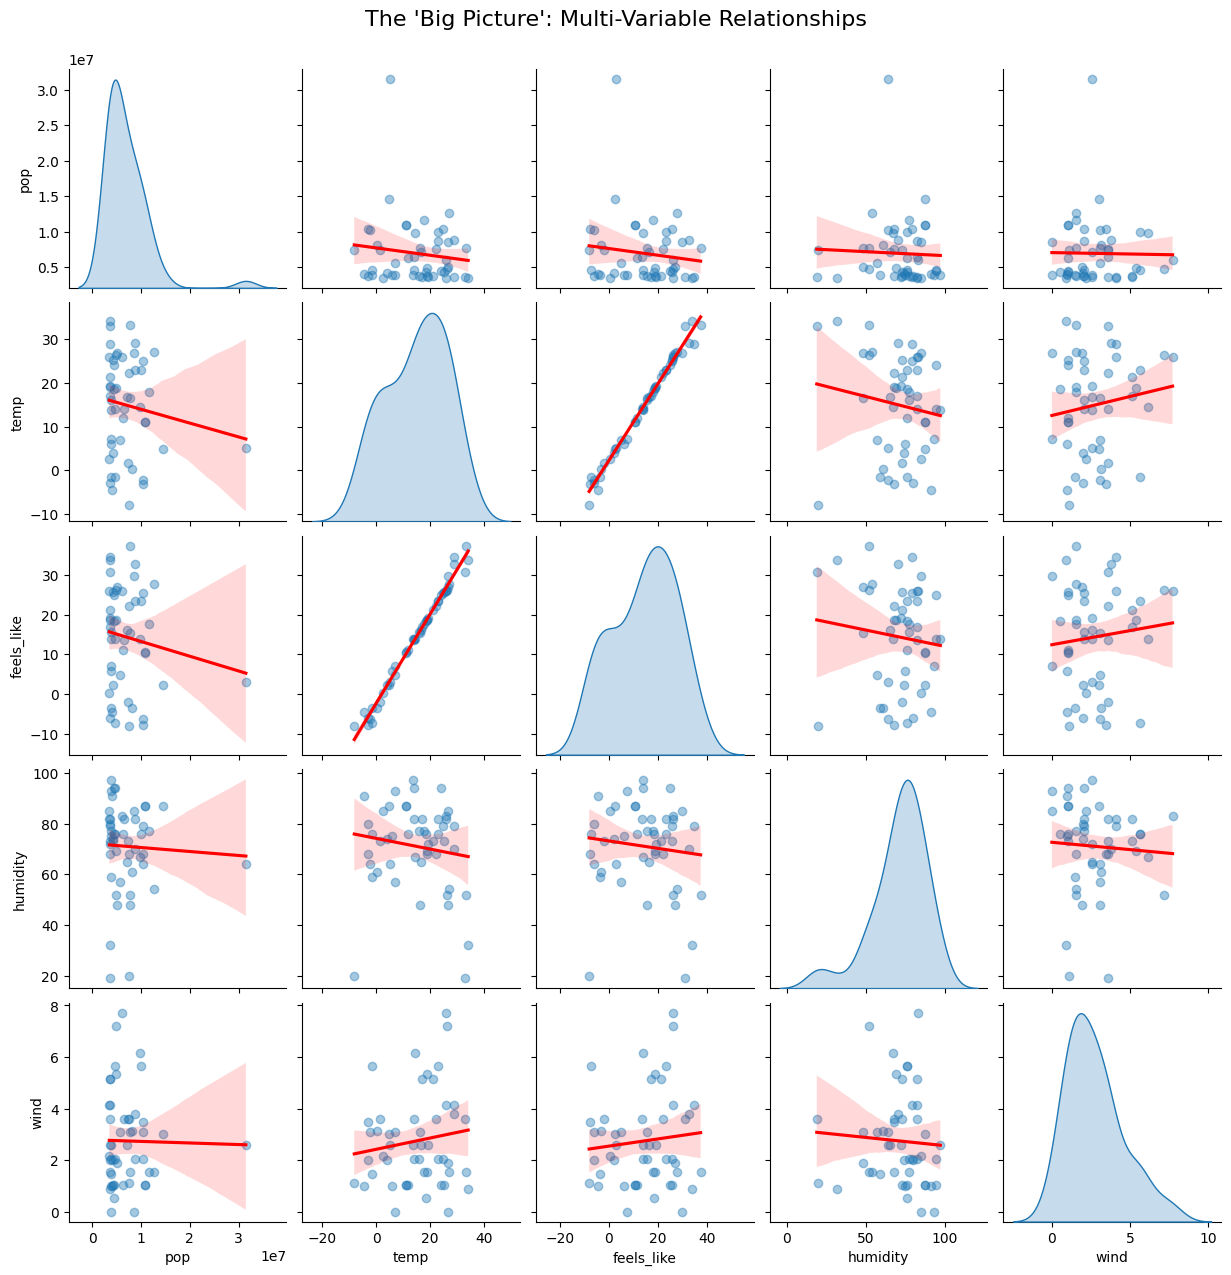

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. We select only the numerical columns that make sense for a beginner to compare
# We exclude lat/lng for now to focus on the 'Weather vs People' story
cols_to_plot = ['pop', 'temp', 'feels_like', 'humidity', 'wind']

# 2. Create the Pairplot
# 'diag_kind' shows the univariate distribution (histogram) on the diagonal
# 'kind=reg' adds a trend line to the scatter plots to show correlations
plot = sns.pairplot(
    master_df[cols_to_plot],
    diag_kind='kde',
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.4}}
)

# Add a title to the figure
plot.fig.suptitle("The 'Big Picture': Multi-Variable Relationships", y=1.02, fontsize=16)

plt.show()

## 2.3 The Correlation Heatmap
While the pairplot is visual, the Heatmap provides the exact mathematical correlation coefficient (Pearson's $r$). This is essential for a "Gold Template" because it allows you to say exactly how strong a relationship is on a scale of -1 to +1.

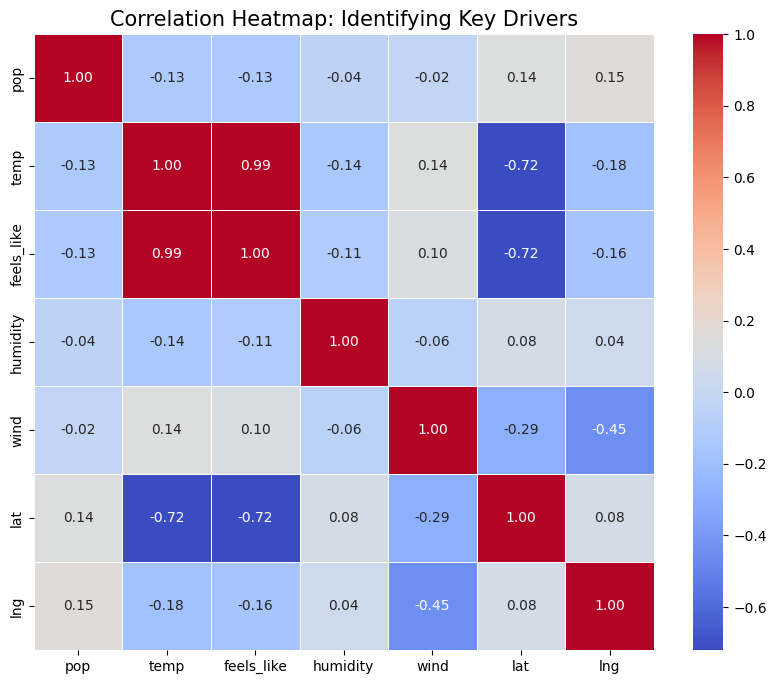

In [7]:
# Select numerical columns
numerical_df = master_df[['pop', 'temp', 'feels_like', 'humidity', 'wind', 'lat', 'lng']]

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Identifying Key Drivers", fontsize=15)
plt.show()

## 2.4 Spatial Mapping
You are working with global city data. A DS project feels incomplete if you don't show where these cities are. Using a simple scatter plot as a "map" is a brilliant way to show the relationship between Latitude and Temperature.

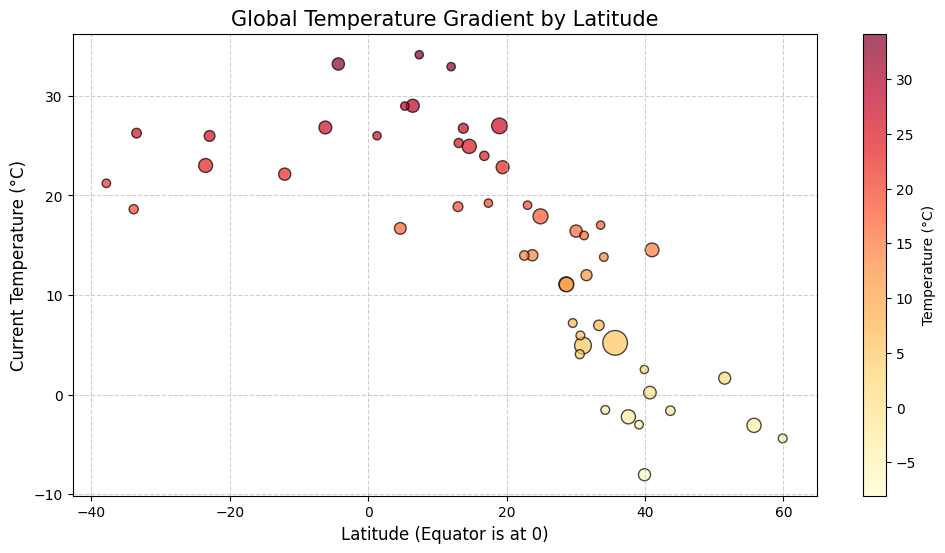

In [8]:
plt.figure(figsize=(12, 6))
# We use Latitude on the X-axis because it usually dictates temperature
scatter = plt.scatter(master_df['lat'], master_df['temp'],
                      c=master_df['temp'], cmap='YlOrRd',
                      s=master_df['pop']/100000, alpha=0.7, edgecolors='k')

plt.colorbar(scatter, label='Temperature (°C)')
plt.title('Global Temperature Gradient by Latitude', fontsize=15)
plt.xlabel('Latitude (Equator is at 0)', fontsize=12)
plt.ylabel('Current Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#3. Data Wrangling
Goal: Clean the data for the machine. This is where your team will spend most of their time.

## 3.1 Type Conversion & Standardization
Computers are very specific. Sometimes, numbers are imported as "Objects" (strings of text). You cannot calculate the average of a word! This first step ensures that our math-heavy columns are explicitly recognized as numbers by Python.

In [9]:
# --- STEP 1: TYPE CONVERSION ---
# We ensure population is an integer and weather metrics are floats (decimals)
cols_to_fix = {
    'pop': 'int64',
    'temp': 'float64',
    'feels_like': 'float64',
    'humidity': 'float64',
    'wind': 'float64'
}

for col, dtype in cols_to_fix.items():
    master_df[col] = pd.to_numeric(master_df[col], errors='coerce')

# Drop any rows where the conversion failed (resulting in NaNs)
master_df = master_df.dropna(subset=['pop', 'temp'])

print("✅ Step 1: Types converted to numeric. Data is now 'math-ready'.")
master_df.dtypes

✅ Step 1: Types converted to numeric. Data is now 'math-ready'.


,0
city,object
pop,float64
temp,float64
feels_like,float64
humidity,int64
wind,float64
condition,object
lat,float64
lng,float64


## 3.2 Handling Missing Values (Imputation)
In a global dataset, some sensors might fail, or some cities might lack data. Instead of just deleting everything, we use Imputation. For a beginner template, we use the Median to fill gaps because it is "robust"—meaning it isn't easily skewed by one or two extreme "outlier" cities.

In [10]:
# --- STEP 2: HANDLING MISSING VALUES ---
# We fill missing humidity or wind values with the 'Median' (the middle value)
# This keeps our dataset size large enough for Machine Learning
master_df['humidity'] = master_df['humidity'].fillna(master_df['humidity'].median())
master_df['wind'] = master_df['wind'].fillna(master_df['wind'].median())

print(f"✅ Step 2: Missing values imputed. Total rows remaining: {len(master_df)}")

✅ Step 2: Missing values imputed. Total rows remaining: 50


## 3.3 Feature Engineering (The UHI Index)
This is where we go from being "data collectors" to "data scientists." We create a new column, the Urban Heat Island (UHI) Index, which measures the difference between the actual air temperature and how hot it actually feels to a human. This new metric will be the "Target" we try to predict later.

In [11]:
# --- STEP 3: FEATURE ENGINEERING ---
# We calculate the 'Heat Gap' (UHI Index)
# A higher index suggests a stronger Urban Heat Island effect
master_df['uhi_index'] = master_df['feels_like'] - master_df['temp']

print("✅ Step 3: New Feature 'uhi_index' created successfully.")
master_df[['city', 'temp', 'feels_like', 'uhi_index']].head()

✅ Step 3: New Feature 'uhi_index' created successfully.


,city,temp,feels_like,uhi_index
0,tokyo,5.19,3.07,-2.12
1,shanghai,4.92,2.41,-2.51
2,bombay,26.99,27.66,0.67
3,karachi,17.90,17.76,-0.14
4,new delhi,11.09,10.53,-0.56


## 3.4 Binning & Categorization
To help beginners understand patterns, we can "bin" our continuous data into categories. For example, instead of just looking at raw population numbers, we can group cities into Low, Medium, and High Density. This makes our final charts much easier to read.

In [12]:
# --- STEP 4: BINNING (CATEGORIZATION) ---
# We group cities into 3 equal-sized 'Population Tiers'
master_df['pop_tier'] = pd.qcut(
    master_df['pop'],
    q=3,
    labels=['Tier 3 (Large)', 'Tier 2 (Major)', 'Tier 1 (Megacity)']
)

# Final cleanup: Reordering columns for a professional look
master_df = master_df[[
    'city', 'pop', 'pop_tier', 'temp', 'feels_like',
    'uhi_index', 'humidity', 'wind', 'lat', 'lng'
]]

print("✅ Step 4: Cities categorized by population tier. Wrangling complete!")
master_df.head()

✅ Step 4: Cities categorized by population tier. Wrangling complete!


,city,pop,pop_tier,temp,feels_like,uhi_index,humidity,wind,lat,lng
0,tokyo,31480498.0,Tier 1 (Megacity),5.19,3.07,-2.12,64,2.57,35.685000,139.751389
1,shanghai,14608512.0,Tier 1 (Megacity),4.92,2.41,-2.51,87,3.00,31.045556,121.399722
2,bombay,12692717.0,Tier 1 (Megacity),26.99,27.66,0.67,54,1.54,18.975000,72.825833
3,karachi,11627378.0,Tier 1 (Megacity),17.90,17.76,-0.14,77,1.54,24.905600,67.082200
4,new delhi,10928270.0,Tier 1 (Megacity),11.09,10.53,-0.56,87,1.03,28.600000,77.200000


#4. Advanced Visualization
Goal: Storytelling. Move beyond simple bars to multi-dimensional charts.

## 4.1 The Interactive "Bubble" Map (Geospatial Analysis)
Since the Urban Heat Island (UHI) effect is a geographic problem, a flat scatter plot isn't enough. We use a Bubble Map where:

Position = Latitude/Longitude.

Color = UHI Index (Intensity).

Size = Population (Density).

In [13]:
import plotly.express as px

fig = px.scatter_geo(master_df,
                     lat='lat',
                     lon='lng',
                     color='uhi_index',
                     size='pop',
                     hover_name='city',
                     projection="natural earth",
                     title="Global UHI Intensity Map",
                     color_continuous_scale=px.colors.sequential.YlOrRd)

fig.show()

## 4.2 Multi-Panel Regression (The "Driver" Analysis)
To solve the problem, we need to know which factor "drives" the UHI index most: Population, Humidity, or Wind? Using a FacetGrid, we can plot all drivers side-by-side with their own regression lines to see which has the steepest slope.

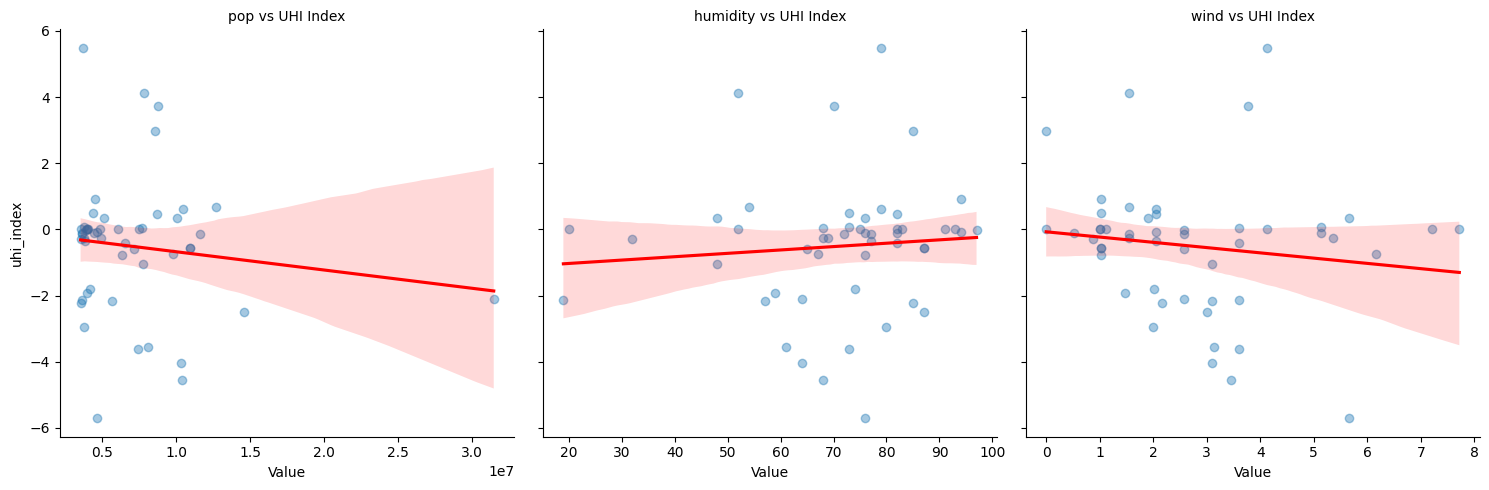

In [14]:
# Melt the data to make it 'long-form' for FacetGrid
melted_df = master_df.melt(id_vars=['city', 'uhi_index'],
                           value_vars=['pop', 'humidity', 'wind'],
                           var_name='Feature', value_name='Value')

g = sns.FacetGrid(melted_df, col="Feature", sharex=False, height=5)
g.map(sns.regplot, "Value", "uhi_index", scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
g.set_titles("{col_name} vs UHI Index")
plt.show()

## 4.3 Joint Distribution Plot (Density & Risk)
This is a "Gold Standard" chart. It combines a scatter plot with marginal histograms. It allows us to see the density of our cities. Are the highest UHI Index values concentrated in the highest population cities?

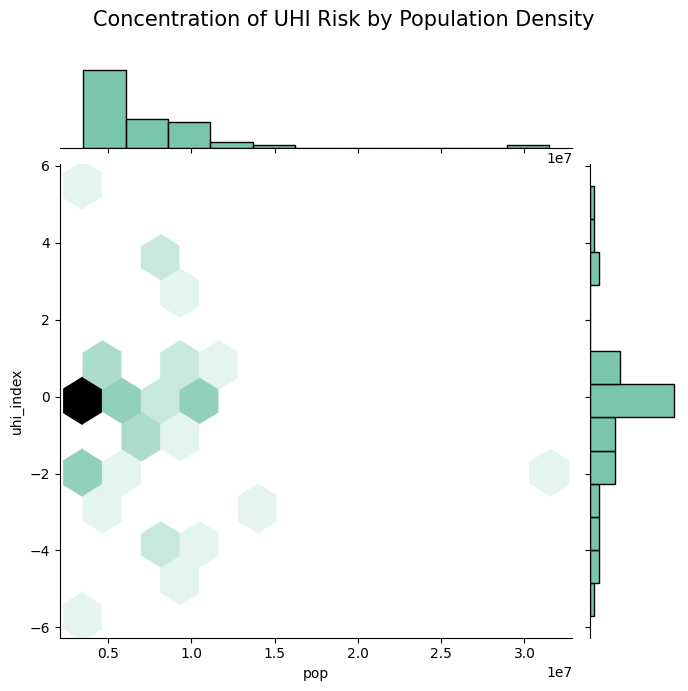

In [15]:
sns.jointplot(data=master_df, x="pop", y="uhi_index",
              kind="hex", color="#4CB391", height=7)
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle("Concentration of UHI Risk by Population Density", fontsize=15)
plt.show()

#5. Machine Learning (ML)
Goal: The predictive engine.

##5.1 Feature Selection & Target Definition
In ML, we have Features ($X$)—the ingredients—and a Target ($y$)—the result we want to predict.Target ($y$): feels_likeFeatures ($X$): pop, temp, humidity, wind, lat (We exclude city because models can't "read" names easily without extra steps).

In [16]:
# 1. Define our features and target
X = master_df[['pop', 'temp', 'humidity', 'wind', 'lat']]
y = master_df['feels_like']

print("✅ Features and Target defined.")
print(f"Features: {X.columns.tolist()}")

✅ Features and Target defined.
Features: ['pop', 'temp', 'humidity', 'wind', 'lat']


##5.2 The Train-Test Split
If we test the model on the same data it learned from, it will just "cheat" by memorizing the answers. This is called Overfitting. We split our data: 80% for the model to study (Train) and 20% to act as a final exam (Test).

In [17]:
from sklearn.model_selection import train_test_split

# We split the data (random_state=42 ensures the split is the same every time you run it)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📈 Training on {len(X_train)} cities | Testing on {len(X_test)} cities.")

📈 Training on 40 cities | Testing on 10 cities.


##5.3 Model Selection & Training
For beginners, Linear Regression is the perfect starting point. It tries to draw a straight line through the data points to find the best relationship between your features and the temperature.

In [18]:
from sklearn.linear_model import LinearRegression

# 1. Initialize the model
model = LinearRegression()

# 2. Train the model (This is where the learning happens!)
model.fit(X_train, y_train)

print("🤖 Model training complete!")

🤖 Model training complete!


 ## 5.4 Evaluation (The "Grade Card")
 Finally, we ask the model to predict the temperatures for our "Test" cities. We compare its guesses to the actual numbers. We use two main metrics:MAE (Mean Absolute Error): On average, how many degrees ($^{\circ}$C) was the model off by?$R^{2}$ Score: A percentage showing how much of the temperature variance our model explains (1.0 is a perfect score).

In [19]:
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Performance:")
print(f"   - Mean Absolute Error: {mae:.2f}°C")
print(f"   - R² Score: {r2:.2f}")

📊 Model Performance:
   - Mean Absolute Error: 0.67°C
   - R² Score: 0.99


###5.4.1 Prediction vs. Reality (The Identity Plot)
In a perfect world, every dot would fall exactly on a diagonal line ($y = x$). The closer our dots are to this line, the more accurate our model is.

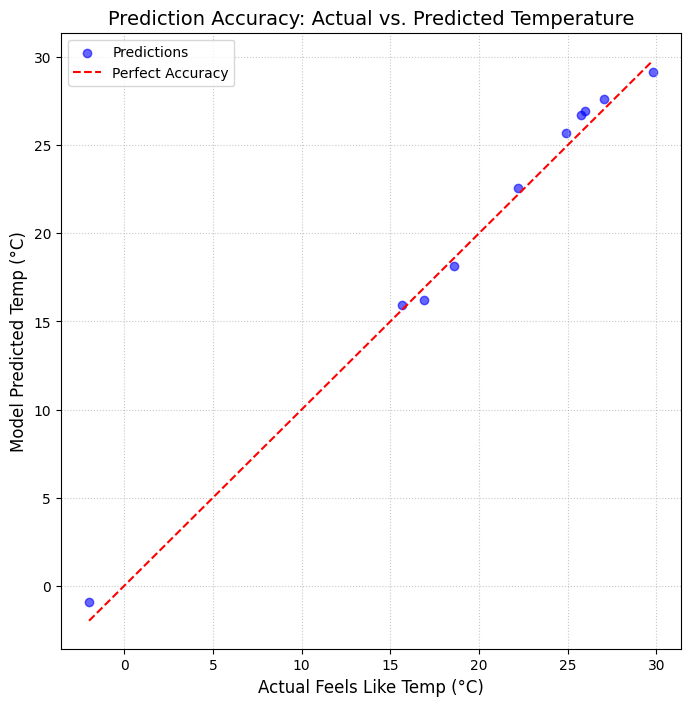

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
# Plotting the Actual vs Predicted
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predictions')

# Plotting the 'Perfect Match' line
line_coords = [y_test.min(), y_test.max()]
plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Perfect Accuracy')

plt.title('Prediction Accuracy: Actual vs. Predicted Temperature', fontsize=14)
plt.xlabel('Actual Feels Like Temp (°C)', fontsize=12)
plt.ylabel('Model Predicted Temp (°C)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

###5.4.2 Residual Distribution (Checking for Bias)
A "Residual" is simply the error: $Actual - Predicted$. A good model should have residuals that are normally distributed around zero. If the "hump" is shifted to the left or right, your model is consistently over-predicting or under-predicting.

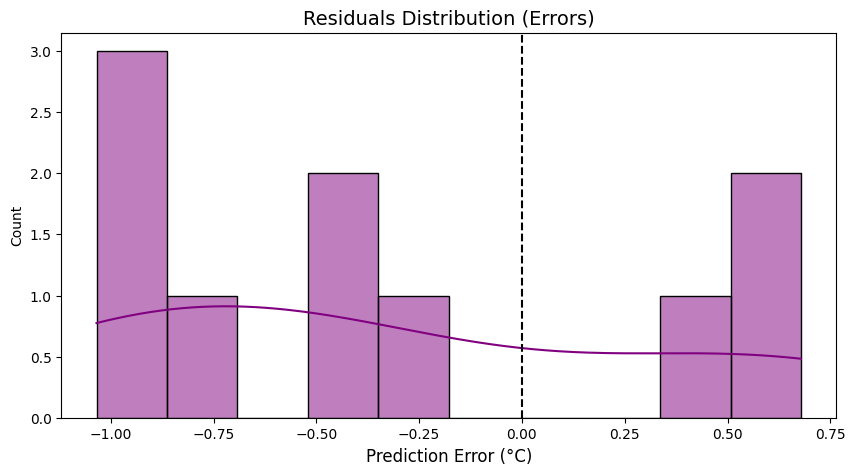

In [21]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple', bins=10)
plt.axvline(0, color='black', linestyle='--')
plt.title('Residuals Distribution (Errors)', fontsize=14)
plt.xlabel('Prediction Error (°C)', fontsize=12)
plt.show()

###5.4.3 Feature Importance (The "Why" Factor)
Beginners always ask: "Which factor helped the model the most?" We can visualize the coefficients of our linear model. This tells us exactly how many degrees the feels_like temperature changes for every unit increase in pop, humidity, or wind.

/tmp/ipython-input-340513562.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




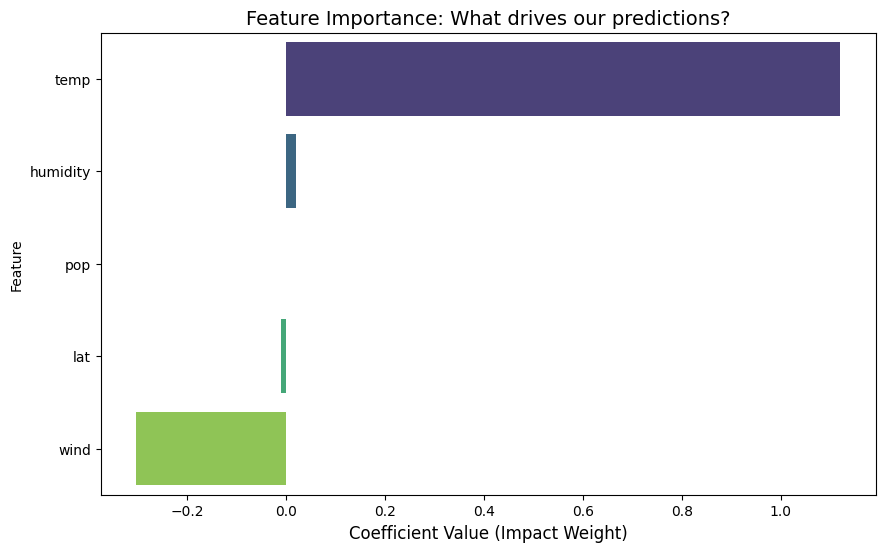

In [22]:
# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance: What drives our predictions?', fontsize=14)
plt.xlabel('Coefficient Value (Impact Weight)', fontsize=12)
plt.show()